In [1]:
!pip install gym

In [2]:
!pip install gym==0.19

In [3]:
!pip install atari-py

In [4]:
!python -m atari_py.import_roms '/Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms'

copying koolaid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Kool-Aid Man (Kool Aid Pitcher Man) (1983) (M Network, Stephen Tatsumi, Jane Terjung - Kool Aid) (MT4648) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/koolaid.bin
copying alien.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/alien.bin
copying demon_attack.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Demon Attack (Death from Above) (1982) (Imagic, Rob Fulop) (720000-200, 720101-1B, 720101-1C, IA3200, IA3200C, IX-006-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/demon_attack.bin
copying crazy_climber.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Crazy Climber (1983) (Atari - Rokl

copying tennis.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Tennis - Le Tennis (1981) (Activision, Alan Miller) (AG-007, CAG-007) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/tennis.bin
copying space_invaders.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/space_invaders.bin
copying up_n_down.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Up 'n Down (1984) (SEGA - Beck-Tech, Steve Beck, Phat Ho) (009-01) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/up_n_down.bin
copying galaxian.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Galaxian (1983) (Atari - GCC, Mark Ackerman, Tom Calderwood, Glenn Parker) (CX2684) ~.bin to /Users/srikanth/opt/anaconda3/lib/pyth

copying boxing.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Boxing - La Boxe (1980) (Activision, Bob Whitehead) (AG-002, CAG-002, AG-002-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/boxing.bin
copying fishing_derby.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Fishing Derby (1980) (Activision, David Crane) (AG-004) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/fishing_derby.bin
copying kaboom.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Kaboom! (Paddle) (1981) (Activision, Larry Kaplan, David Crane) (AG-010, CAG-010, AG-010-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/kaboom.bin
copying freeway.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Freeway (1981) (Activision, David Crane) (AG-009, AG-009-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-pa

In [5]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym
import time
start_time=time.time()

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save_200_1e-2.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was {}. running mean: {}'.format(reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save_200_1e-2.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        if running_reward>=-19:
            break
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
end_time=time.time()
td_model=end_time-start_time
print('Time difference for model is %s seconds:' %(td_model))

        

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_10935/3484313919.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -21.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: 1.0 !!!!!!!!
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: g

ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.924857558959538
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: ga

ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.932042523250605
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: ga

ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: 1.0 !!!!!!!!
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.928540476165022
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
e

ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.887515393666433
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: ga

ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.898270938317506
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: ga

ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.907998060106898
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: ga

ep 70: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.91679509469465
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.917627143747705
ep 72: game finished, reward: -1.0
ep 72: game finished, reward: -1.0

ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.925503465338153
ep 82: game finished, reward: -1.0
ep 82: game finished, reward: -1.0
ep 82: game finished, reward: -1.0
ep 82: game finished, reward: -1.0
ep 82: game finished, reward: -1.0
ep 82: game finished, reward: -1.0
ep 82: ga

ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.93262666940156
ep 92: game finished, reward: -1.0
ep 92: game finished, reward: -1.0
ep 92: game finished, reward: -1.0
ep 92: game finished, reward: -1.0
ep 92: game finished, reward: -1.0
ep 92: game finished, reward: -1.0
ep 92: game finished, reward: -1.0
ep 92: gam

ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.939068767473138
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finished, reward: -1.0
ep 102: game finish

ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
ep 111: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.94489488549452
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finished, reward: -1.0
ep 112: game finishe

ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
ep 121: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.95016392219995
ep 122: game finished, reward: -1.0
ep 122: game finished, reward: -1.0
ep 122: game finished, reward: -1.0
ep 122: game finished, reward: -1.0
ep 122: game finished, reward: -1.0
ep 122: game finished, reward: -1.0
ep 122: game finished, reward: -1.0
ep 122: game finished, reward: -1.0
ep 122: game finishe

ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
ep 131: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.9549291445489
ep 132: game finished, reward: -1.0
ep 132: game finished, reward: -1.0
ep 132: game finished, reward: -1.0
ep 132: game finished, reward: -1.0
ep 132: game finished, reward: -1.0
ep 132: game finished

ep 140: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.958826996186588
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
ep 141: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.959238726224722
ep 142: game finished, reward: -1.0
ep 142: ga

ep 150: game finished, reward: -1.0
ep 150: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.962763873376883
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
ep 151: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.963136234643116
ep 152: ga

ep 160: game finished, reward: -1.0
ep 160: game finished, reward: -1.0
ep 160: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.966324314539307
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
ep 161: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 170: game finished, reward: -1.0
ep 170: game finished, reward: -1.0
ep 170: game finished, reward: -1.0
ep 170: game finished, reward: -1.0
ep 170: game finished, reward: -1.0
ep 170: game finished, reward: -1.0
ep 170: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.969544313705722
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finished, reward: -1.0
ep 171: game finish

ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
ep 180: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.96275343323337
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finished, reward: -1.0
ep 181: game finishe

ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
ep 190: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.966314872660647
ep 191: game finished, reward: -1.0
ep 191: game finished, reward: -1.0
ep 191: game finished, reward: -1.0
ep 191: game finished, reward: -1.0
ep 191: game finished, reward: -1.0
ep 191: game finished, reward: -1.0
ep 191: game finished, reward: -1.0
ep 191: game finished, reward: -1.0
ep 191: game finished, reward: -1.0
ep 191: game finished, reward: -1.0
ep 191: game finish

ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
ep 200: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.9695357746399
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished

ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.972448700655306
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finish

resetting env. episode reward total was -21.0. running mean: -20.97483141285804
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.97508309872946
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game

ep 229: game finished, reward: -1.0
ep 229: game finished, reward: -1.0
ep 229: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.967823179441513
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 239: game finished, reward: -1.0
ep 239: game finished, reward: 1.0 !!!!!!!!
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.932461415283054
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: game finished, reward: -1.0
ep 240: gam

ep 249: game finished, reward: 1.0 !!!!!!!!
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: 1.0 !!!!!!!!
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.87126021615838
ep 250: game finished, reward: -1.0
ep 250: game finished, reward: -1.0
ep 250: game finished, reward: -1.0
ep 250: game finished, reward: -1.0
ep 2

ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.85318308652437
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: 1.0 !!!!!!!!
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: 1.0 !!!!!!!!
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 259: game finished, reward: -1.0
ep 2

ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
ep 268: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.829823623250572
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finished, reward: -1.0
ep 269: game finish

ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
ep 278: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.826295535277875
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: 1.0 !!!!!!!!
ep 279: game finished, reward: -1.0
ep 279: game finished, reward: -1.0
ep 279: gam

ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
ep 287: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.802390528567148
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
ep 288: game finished, reward: -1.0
resetting env. epis

ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
ep 297: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.82128553618417
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finished, reward: -1.0
ep 298: game finishe

ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: 1.0 !!!!!!!!
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
ep 307: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.780233387903085
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: 1.0 !!!!!!!!
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 308: game finished, reward: -1.0
ep 

ep 316: game finished, reward: -1.0
ep 316: game finished, reward: 1.0 !!!!!!!!
ep 316: game finished, reward: -1.0
ep 316: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.751760872060796
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: 1.0 !!!!!!!!
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: 1.0 !!!!!!!!
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: -1.0
ep 317: game finished, reward: 

ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
ep 326: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.738301935433284
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finished, reward: -1.0
ep 327: game finish

ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
ep 335: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.60621525293952
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: 1.0 !!!!!!!!
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game finished, reward: -1.0
ep 336: game

ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: 1.0 !!!!!!!!
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
ep 345: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.567470861834497
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: game finished, reward: -1.0
ep 346: gam

ep 354: game finished, reward: -1.0
ep 354: game finished, reward: 1.0 !!!!!!!!
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: 1.0 !!!!!!!!
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: 1.0 !!!!!!!!
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
ep 354: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.52713361965457
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: -1.0
ep 355: game finished, reward: 1.0 !!!!!!!!
ep 355: game finished, reward: -1.0
ep 355: game finished, r

ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: 1.0 !!!!!!!!
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
ep 364: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.515927501399833
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
ep 365: game finished, reward: -1.0
ep 365: gam

ep 373: game finished, reward: -1.0
ep 373: game finished, reward: -1.0
ep 373: game finished, reward: -1.0
ep 373: game finished, reward: -1.0
ep 373: game finished, reward: -1.0
ep 373: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.510900966519674
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: 1.0 !!!!!!!!
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: game finished, reward: -1.0
ep 374: gam

ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
ep 383: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.529414637247417
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: 1.0 !!!!!!!!
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: game finished, reward: -1.0
ep 384: gam

ep 392: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.512651134088824
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
ep 393: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.517524622747935
ep 394: game finished, reward: -1.0
ep 394: ga

ep 402: game finished, reward: 1.0 !!!!!!!!
ep 402: game finished, reward: -1.0
ep 402: game finished, reward: -1.0
ep 402: game finished, reward: 1.0 !!!!!!!!
ep 402: game finished, reward: -1.0
ep 402: game finished, reward: -1.0
ep 402: game finished, reward: -1.0
ep 402: game finished, reward: -1.0
ep 402: game finished, reward: -1.0
ep 402: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.51080811443593
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 403: game finished, reward: -1.0
ep 4

ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: 1.0 !!!!!!!!
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: 1.0 !!!!!!!!
ep 412: game finished, reward: -1.0
ep 412: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.5080816274561
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: 1.0 !!!!!!

ep 421: game finished, reward: -1.0
ep 421: game finished, reward: -1.0
ep 421: game finished, reward: -1.0
ep 421: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.502674873788774
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
ep 422: game finished, reward: -1.0
resetting env. epis

ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: 1.0 !!!!!!!!
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
ep 431: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.473637574022504
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: gam

ep 440: game finished, reward: -1.0
ep 440: game finished, reward: -1.0
ep 440: game finished, reward: -1.0
ep 440: game finished, reward: -1.0
ep 440: game finished, reward: -1.0
ep 440: game finished, reward: -1.0
ep 440: game finished, reward: -1.0
ep 440: game finished, reward: -1.0
ep 440: game finished, reward: -1.0
ep 440: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.423372799363197
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: 1.0 !!!!!!!!
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: 1.0 !!!!!!!!
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: 

ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: 1.0 !!!!!!!!
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: 1.0 !!!!!!!!
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: 1.0 !!!!!!!!
ep 450: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.39189025040855
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -

ep 459: game finished, reward: -1.0
ep 459: game finished, reward: -1.0
ep 459: game finished, reward: -1.0
ep 459: game finished, reward: -1.0
ep 459: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.4165164609977
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: 1.0 !!!!!!!!
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game 

ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.453566813688784
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: 1.0 !!!!!!!!
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: game finished, reward: -1.0
ep 470: gam

ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: 1.0 !!!!!!!!
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: 1.0 !!!!!!!!
ep 479: game finished, reward: -1.0
ep 479: game finished, reward: 1.0 !!!!!!!!
ep 479: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.429205734632937
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: -1.0
ep 480: game finished, reward: 

ep 488: game finished, reward: 1.0 !!!!!!!!
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: 1.0 !!!!!!!!
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: -1.0
ep 488: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.391795605070282
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 489: game finished, reward: -1.0
ep 

ep 497: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.396539734713002
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: 1.0 !!!!!!!!
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: 1.0 !!!!!!!!
ep 498: game finished, reward: -1.0
ep 498: game finished, reward: -1.0
resetting env. episode reward total was

ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
ep 507: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.32113531272984
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finished, reward: -1.0
ep 508: game finishe

ep 516: game finished, reward: -1.0
ep 516: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.341700043999044
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: 1.0 !!!!!!!!
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
ep 517: game finished, reward: -1.0
resetting env. episode reward total was -20.0. 

ep 526: game finished, reward: -1.0
ep 526: game finished, reward: -1.0
ep 526: game finished, reward: -1.0
ep 526: game finished, reward: -1.0
ep 526: game finished, reward: -1.0
ep 526: game finished, reward: -1.0
ep 526: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.385807157338817
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finished, reward: -1.0
ep 527: game finish

ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
ep 536: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.378625705119962
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finished, reward: -1.0
ep 537: game finish

ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
ep 545: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.365977093347894
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: 1.0 !!!!!!!!
ep 546: game finished, reward: -1.0
ep 546: game finished, reward: -1.0
ep 546: gam

ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
ep 555: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.36068223061746
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finished, reward: -1.0
ep 556: game finishe

ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
ep 564: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35015415019164
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: 1.0 !!!!!!!!
ep 565: game finished, reward: -1.0
ep 565: game finished, reward: -1.0
ep 565: game

ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: 1.0 !!!!!!!!
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: 1.0 !!!!!!!!
ep 574: game finished, reward: -1.0
ep 574: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.33483304884061
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 575: game finished, reward: -1.0
ep 5

ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
ep 583: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.343449557559794
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: 1.0 !!!!!!!!
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: 1.0 !!!!!!!!
ep 584: game finished, reward: -1.0
ep 584: game finished, reward: -1.0
ep 

ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35039214560721
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finishe

ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35034743164022
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finishe

ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.34530665503385
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: 1.0 !!!!!!!!
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game finished, reward: -1.0
ep 613: game

ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
ep 621: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.325821078499025
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: -1.0
ep 622: game finished, reward: 1.0 !!!!!!!!
ep 622: game finished, reward: -1.0
ep 622: gam

ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: 1.0 !!!!!!!!
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: -1.0
ep 631: game finished, reward: 1.0 !!!!!!!!
ep 631: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.31358951239708
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 632: game finished, reward: -1.0
ep 6

ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: 1.0 !!!!!!!!
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
ep 640: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.286862438700723
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: game finished, reward: -1.0
ep 641: gam

ep 649: game finished, reward: -1.0
ep 649: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.251290945731675
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: 1.0 !!!!!!!!
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: 1.0 !!!!!!!!
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
ep 650: game finished, reward: -1.0
res

ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
ep 659: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.256176199928987
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finished, reward: -1.0
ep 660: game finish

ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
ep 669: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.32729908825085
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 670: game finished, reward: -1.0
ep 670: game finishe

ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
ep 678: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.33733661064111
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: -1.0
ep 679: game finished, reward: 1.0 !!!!!!!!
ep 679: game finished, reward: -1.0
resetting en

ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
ep 688: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.363601975987194
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finished, reward: -1.0
ep 689: game finish

ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
ep 697: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.303243677669496
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: -1.0
ep 698: game finished, reward: 1.0 !!!!!!!!
ep 698: game finished, reward: -1.0
ep 698: gam

ep 707: game finished, reward: 1.0 !!!!!!!!
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: 1.0 !!!!!!!!
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
ep 707: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.283188296767392
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 708: game finished, reward: -1.0
ep 

ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: 1.0 !!!!!!!!
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
ep 716: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.257717243981528
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: game finished, reward: -1.0
ep 717: gam

ep 725: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.234459505881414
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
ep 726: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2421149108226
ep 727: game finished, reward: -1.0
ep 727: game

ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: 1.0 !!!!!!!!
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
ep 735: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.2314594923492
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game finished, reward: -1.0
ep 736: game 

ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
ep 745: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.295144740962453
ep 746: game finished, reward: -1.0
ep 746: game finished, reward: -1.0
ep 746: game finished, reward: -1.0
ep 746: game finished, reward: -1.0
ep 746: game finished, reward: -1.0
ep 746: game finished, reward: -1.0
ep 746: game finished, reward: -1.0
ep 746: game finished, reward: -1.0
ep 746: game finished, reward: -1.0
ep 746: game finish

ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
ep 754: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.29777393041058
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: 1.0 !!!!!!!!
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: 1.0 !!!!!!!!
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 755: game finished, reward: -1.0
ep 7

ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: 1.0 !!!!!!!!
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
ep 764: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.299169515676798
ep 765: game finished, reward: -1.0
ep 765: game finished, reward: -1.0
ep 765: game finished, reward: -1.0
ep 765: game finished, reward: -1.0
ep 765: game finished, reward: -1.0
ep 765: game finished, reward: -1.0
ep 765: game finished, reward: -1.0
ep 765: game finished, reward: -1.0
ep 765: game finished, reward: -1.0
ep 765: gam

ep 773: game finished, reward: -1.0
ep 773: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.32106433490845
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
ep 774: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.327853691559366
ep 775: gam

ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: 1.0 !!!!!!!!
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: 1.0 !!!!!!!!
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
ep 783: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.298733271119016
ep 784: game finished, reward: -1.0
ep 784: game finished, reward: -1.0
ep 784: game finished, reward: -1.0
ep 784: game finished, reward: -1.0
ep 784: game finished, reward: -1.0
ep 784: game finished, reward: -1.0
ep 784: game finished, reward: -1.0
ep 784: game finished, reward: -1.0
ep 

ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: 1.0 !!!!!!!!
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: -1.0
ep 792: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.223601710615704
ep 793: game finished, reward: -1.0
ep 793: game finished, reward: -1.0
ep 793: game finished, reward: -1.0
ep 793: game finished, reward: -1.0
ep 793: game finished, reward: -1.0
ep 793: game finished, reward: 1.0 !!!!!!!!
ep 793: game finished, reward: -1.0
ep 793: game finished, reward: -1.0
ep 793: game finished, reward: -1.0
ep 793: game finished, reward: -1.0
ep 793: game finished, reward: 

ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
ep 801: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.194949275649087
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finished, reward: -1.0
ep 802: game finish

ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
ep 811: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.204764572250344
ep 812: game finished, reward: -1.0
ep 812: game finished, reward: -1.0
ep 812: game finished, reward: -1.0
ep 812: game finished, reward: -1.0
ep 812: game finished, reward: -1.0
ep 812: game finish

ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
ep 820: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.207809093149685
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finished, reward: -1.0
ep 821: game finish

ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
ep 829: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.161892726209977
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: 1.0 !!!!!!!!
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: 1.0 !!!!!!!!
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 830: game finished, reward: -1.0
ep 

ep 839: game finished, reward: 1.0 !!!!!!!!
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: 1.0 !!!!!!!!
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: -1.0
ep 839: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -20.145616211261846
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: -1.0
ep 840: game finished, reward: 

ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
ep 848: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.160103673017282
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: -1.0
ep 849: game finished, reward: 1.0 !!!!!!!!
ep 849: gam

ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
ep 858: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.144901607071173
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finished, reward: -1.0
ep 859: game finish

resetting env. episode reward total was -21.0. running mean: -20.20021062132568
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: -1.0
ep 868: game finished, reward: 1.0 !!!!!!!!
ep 868: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.198208515112423
ep 869: game finished, reward: -1.0
ep 

ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
ep 877: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20961113559161
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finished, reward: -1.0
ep 878: game finishe

ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.199942259943935
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: 1.0 !!!!!!!!
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: 1.0 !!!!!!!!
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: -1.0
ep 887: game finished, reward: 1.0 !!!!!!!!
ep 887: game finished, reward: 

ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
ep 896: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.191878249410717
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finished, reward: -1.0
ep 897: game finish

ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: -1.0
ep 906: game finished, reward: 1.0 !!!!!!!!
ep 906: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.249348174342316
ep 907: game finished, reward: -1.0
ep 907: game finished, reward: -1.0
ep 907: game finished, reward: -1.0
ep 907: game finished, reward: -1.0
ep 907: game finished, reward: -1.0
ep 907: game finished, reward: -1.0
ep 907: gam

ep 915: game finished, reward: -1.0
ep 915: game finished, reward: 1.0 !!!!!!!!
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
ep 915: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.237301501865346
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: game finished, reward: -1.0
ep 916: gam

ep 925: game finished, reward: -1.0
ep 925: game finished, reward: 1.0 !!!!!!!!
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: 1.0 !!!!!!!!
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
ep 925: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.20374747476433
ep 926: game finished, reward: -1.0
ep 926: game finished, reward: -1.0
ep 926: game finished, reward: -1.0
ep 926: game finished, reward: -1.0
ep 9

ep 934: game finished, reward: -1.0
ep 934: game finished, reward: 1.0 !!!!!!!!
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
ep 934: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.166416932420503
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: game finished, reward: -1.0
ep 935: gam

ep 943: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.150573063611535
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
ep 944: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.15906733297542
ep 945: game finished, reward: -1.0
ep 945: gam

ep 953: game finished, reward: 1.0 !!!!!!!!
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: 1.0 !!!!!!!!
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
ep 953: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.145596989115074
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: 1.0 !!!!!!!!
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: -1.0
ep 954: game finished, reward: 

ep 962: game finished, reward: -1.0
ep 962: game finished, reward: 1.0 !!!!!!!!
ep 962: game finished, reward: -1.0
ep 962: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.12386136734875
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: -1.0
ep 963: game finished, reward: 1.0 !!!!!!!!
ep 963: game finished, reward: -1.0
ep 9

ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -20.026062106608354
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finished, reward: -1.0
ep 972: game finish

ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: 1.0 !!!!!!!!
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.061623183056206
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: game finished, reward: -1.0
ep 982: gam

ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: 1.0 !!!!!!!!
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.00749451601696
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: 1.0 !!!!!!!!
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: 1.0 !!!!!!!!
ep 991: game finished, reward: -1.0
ep 991: game finished, reward: -

ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.007806180309736
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0

resetting env. episode reward total was -20.0. running mean: -20.006365349578253
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: 1.0 !!!!!!!!
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.00630169608247
ep 1010: game fin

ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: 1.0 !!!!!!!!
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: 1.0 !!!!!!!!
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.00515880558954
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game finished, reward: -1.0
ep 1019: game fi

ep 1026: game finished, reward: -1.0
ep 1026: game finished, reward: -1.0
ep 1026: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.917807817097323
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: 1.0 !!!!!!!!
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: 1.0 !!!!!!!!
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game f

ep 1035: game finished, reward: -1.0
ep 1035: game finished, reward: -1.0
ep 1035: game finished, reward: -1.0
ep 1035: game finished, reward: 1.0 !!!!!!!!
ep 1035: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.87724432753546
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, 

resetting env. episode reward total was -19.0. running mean: -19.905727437994546
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: 1.0 !!!!!!!!
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: 1.0 !!!!!!!!
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 1053: game finished, reward: -1.0
ep 1053: game finished, reward: -1.0
ep 1053: game finished, reward: -1.0
ep 1053: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.847309300693322
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward: -1.0
ep 1054: game finished, reward:

ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: 1.0 !!!!!!!!
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: 1.0 !!!!!!!!
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
ep 1063: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.871226836627244
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game f

ep 1072: game finished, reward: -1.0
ep 1072: game finished, reward: -1.0
ep 1072: game finished, reward: 1.0 !!!!!!!!
ep 1072: game finished, reward: -1.0
ep 1072: game finished, reward: 1.0 !!!!!!!!
ep 1072: game finished, reward: -1.0
ep 1072: game finished, reward: -1.0
ep 1072: game finished, reward: -1.0
ep 1072: game finished, reward: -1.0
ep 1072: game finished, reward: -1.0
ep 1072: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.90078539277377
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: 1.0 !!!!!!!!
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073:

ep 1081: game finished, reward: -1.0
ep 1081: game finished, reward: -1.0
ep 1081: game finished, reward: -1.0
ep 1081: game finished, reward: -1.0
ep 1081: game finished, reward: -1.0
ep 1081: game finished, reward: -1.0
ep 1081: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.910126769735772
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: 1.0 !!!!!!!!
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: 1.0 !!!!!!!!
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: 1.0 !!!!!!!!
ep 1082

ep 1090: game finished, reward: -1.0
ep 1090: game finished, reward: -1.0
ep 1090: game finished, reward: -1.0
ep 1090: game finished, reward: 1.0 !!!!!!!!
ep 1090: game finished, reward: -1.0
ep 1090: game finished, reward: -1.0
ep 1090: game finished, reward: -1.0
ep 1090: game finished, reward: -1.0
ep 1090: game finished, reward: -1.0
ep 1090: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.850147192263062
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished, reward: -1.0
ep 1091: game finished,

ep 1099: game finished, reward: -1.0
ep 1099: game finished, reward: -1.0
ep 1099: game finished, reward: -1.0
ep 1099: game finished, reward: -1.0
ep 1099: game finished, reward: -1.0
ep 1099: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.85494007322714
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: -1.0
ep 1100: game finished, reward: 

resetting env. episode reward total was -21.0. running mean: -19.896030444402626
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: 1.0 !!!!!!!!
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
ep 1109: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.8970701399586
ep 1110: game fini

ep 1117: game finished, reward: -1.0
ep 1117: game finished, reward: -1.0
ep 1117: game finished, reward: -1.0
ep 1117: game finished, reward: 1.0 !!!!!!!!
ep 1117: game finished, reward: -1.0
ep 1117: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.826119958643602
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: 1.0 !!!!!!!!
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: 1.0 !!!!!!!!
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118: game finished, reward: -1.0
ep 1118

ep 1126: game finished, reward: -1.0
ep 1126: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.851342947777493
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
ep 1127: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.862

ep 1135: game finished, reward: -1.0
ep 1135: game finished, reward: 1.0 !!!!!!!!
ep 1135: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.824789260406877
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
ep 1136: game finished, reward: -1.0
resetting env. episode 

ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: 1.0 !!!!!!!!
ep 1144: game finished, reward: -1.0
ep 1144: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.792182791355366
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished, reward: -1.0
ep 1145: game finished,

ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
ep 1153: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.78959460500757
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: -1.0
ep 1154: game finished, reward: 

ep 1162: game finished, reward: 1.0 !!!!!!!!
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
ep 1162: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.7881976295521
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: -1.0
ep 1163: game finished, reward: 1.0 !!!!!!!!
ep 1163: game finished, reward: -1.0
ep 1163: game fin

ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
ep 1171: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.768086267958854
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: 1.0 !!!!!!!!
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: -1.0
ep 1172: game finished, reward: 1.0 !!!!!!!!
ep 1172: game finished, reward: -1.0
ep 1172: game f

resetting env. episode reward total was -21.0. running mean: -19.817548843780923
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: 1.0 !!!!!!!!
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
ep 1181: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.819373355343114
ep 1182: game fi

ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: 1.0 !!!!!!!!
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: 1.0 !!!!!!!!
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
ep 1190: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.8050157942732
ep 1191: game finished, reward: -1.0
ep 1191: game finished, reward: -1.0
ep 1191: game fin

ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
ep 1199: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.850516010639897
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward: -1.0
ep 1200: game finished, reward:

ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
ep 1208: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.84316152008095
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: -1.0
ep 1209: game finished, reward: 

ep 1217: game finished, reward: 1.0 !!!!!!!!
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
ep 1217: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.82634888888306
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, reward: -1.0
ep 1218: game finished, 

ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
ep 1226: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.851378320799252
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: 1.0 !!!!!!!!
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: 1.0 !!!!!!!!
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game finished, reward: -1.0
ep 1227: game f

ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
ep 1235: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.855978452276794
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: 1.0 !!!!!!!!
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished, reward: -1.0
ep 1236: game finished,

ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
ep 1244: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.87735471077337
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: 1.0 !!!!!!!!
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, reward: -1.0
ep 1245: game finished, 

ep 1253: game finished, reward: -1.0
ep 1253: game finished, reward: -1.0
ep 1253: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.868278957741932
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
ep 1254: game finished, reward: -1.0
resetting env. episode reward t

resetting env. episode reward total was -19.0. running mean: -19.87899507209001
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
ep 1263: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.89020512136911
ep 1264: game finished, reward: -1.0
ep 1264: game finished, re

ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
ep 1272: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.928334950243535
ep 1273: game finished, reward: -1.0
ep 1273: game finished, reward: -1.0
ep 1273: game finished, reward: -1.0
ep 1273: game finished, reward: -1.0
ep 1273: game finished, reward: -1.0
ep 1273: game finished, reward: -1.0
ep 1273: game finished, reward: -1.0
ep 1273: game finished, reward: -1.0
ep 1273: game finished, reward: -1.0
ep 1273: game finished, reward:

ep 1281: game finished, reward: -1.0
ep 1281: game finished, reward: -1.0
ep 1281: game finished, reward: -1.0
ep 1281: game finished, reward: 1.0 !!!!!!!!
ep 1281: game finished, reward: -1.0
ep 1281: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.96209869202804
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game finished, reward: -1.0
ep 1282: game fi

ep 1290: game finished, reward: -1.0
ep 1290: game finished, reward: -1.0
ep 1290: game finished, reward: -1.0
ep 1290: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.96597428572565
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: 1.0 !!!!!!!!
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: 1.0 !!!!!!!!
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game finished, reward: -1.0
ep 1291: game fi

ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: 1.0 !!!!!!!!
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: -1.0
ep 1300: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.98775553296444
ep 1301: game finished, reward: -1.0
ep 1301: game finished, reward: -1.0
ep 1301: game finished, reward: -1.0
ep 1301: game fi

ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: 1.0 !!!!!!!!
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
ep 1309: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.026185300493133
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished, reward: -1.0
ep 1310: game finished,

ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: 1.0 !!!!!!!!
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
ep 1318: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.947521357236592
ep 1319: game finished, reward: -1.0
ep 1319: game finished, reward: -1.0
ep 1319: game finished, reward: -1.0
ep 1319: game finished, reward: -1.0
ep 1319: game finished,

ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
ep 1327: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.9814696972813
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -1.0
ep 1328: game finished, reward: -

ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.95483660794856
ep 1337: game finished, reward: -1.0
ep 1337: game finished, reward: -1.0
ep 1337: game finished, reward: -1.0
ep 1337: game finished, reward: -1.0
ep 1337: game finished, reward: -1.0
ep 1337: game finished, reward: -1.0
ep 1337: game finished, reward: -1.0
ep 1337: game finished, reward: -1.0
ep 1337: game finished, reward: 1.0 !!!!!!!!
ep 1337: game finished, reward: -1.0
ep 1337: game finished, 

ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: 1.0 !!!!!!!!
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.900986430998653
ep 1346: game finished, reward: -1.0
ep 1346: game finished, reward: -1.0
ep 1346: game finished, reward: -1.0
ep 1346: game finished, reward: -1.0
ep 1346: game finished, reward: -1.0
ep 1346: game finished,

ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: 1.0 !!!!!!!!
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.947402546510705
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished, reward: -1.0
ep 1355: game finished,

ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: 1.0 !!!!!!!!
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: 1.0 !!!!!!!!
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: 1.0 !!!!!!!!
ep 1363: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.949818181081177
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364

ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.973296261744846
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: 1.0 !!!!!!!!
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished,

ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.900666843069082
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: 1.0 !!!!!!!!
ep 1382: game finished,

ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: 1.0 !!!!!!!!
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.881658395649993
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished,

ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.882298627691608
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward:

ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.892960005925975
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
resetting env. episode reward t

ep 1417: game finished, reward: 1.0 !!!!!!!!
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.833016913795106
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: 1.0 !!!!!!!!
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game f

ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: -1.0
ep 1426: game finished, reward: 1.0 !!!!!!!!
ep 1426: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.83736113834359
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, 

ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: 1.0 !!!!!!!!
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.90979308133447
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, 

ep 1444: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.838540223796734
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: 1.0 !!!!!!!!
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: 1.0 !!!!!!!!
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
resetting env. 

ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
ep 1453: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.7675688972089
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -

ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: 1.0 !!!!!!!!
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
ep 1462: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.766229070766048
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished,

ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
ep 1471: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.777226345556716
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: 1.0 !!!!!!!!
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: 1.0 !!!!!!!!
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: 1.0 !!!!!!!!
ep 1472: game finished, reward: -1.0
ep 1472

ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
ep 1480: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.70060582712633
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: 

ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: 1.0 !!!!!!!!
ep 1489: game finished, reward: -1.0
ep 1489: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.716411835629085
ep 1490: game finished, reward: -1.0
ep 1490: game finished, reward: -1.0
ep 1490: game finished, reward: -1.0
ep 1490: game finished, reward: -1.0
ep 1490: game finished, reward: -1.0
ep 1490: game finished, reward: -1.0
ep 1490: game finished, reward: -1.0
ep 1490: game finished, reward: -1.0
ep 1490: game finished, reward: -1.0
ep 1490: game finished, reward: -1.0
ep 1490: game finished,

ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: 1.0 !!!!!!!!
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: 1.0 !!!!!!!!
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
ep 1498: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.655233816160543
ep 1499: game finished, reward: -1.0
ep 1499: game finished, reward: -1.0
ep 1499: game finished, reward: -1.0
ep 1499: game f

ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: 1.0 !!!!!!!!
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: 1.0 !!!!!!!!
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
ep 1507: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.644965896606553
ep 1508: game finished, reward: -1.0
ep 1508: game finished, reward: -1.0
ep 1508: game f

ep 1515: game finished, reward: -1.0
ep 1515: game finished, reward: -1.0
ep 1515: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.595820195701574
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
ep 1516: game finished, reward: -1.0
resetting env. episode reward t

ep 1524: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.620605076027122
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: 1.0 !!!!!!!!
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
ep 1525: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: 1.0 !!!!!!!!
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: 1.0 !!!!!!!!
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
ep 1534: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.67570573399366
ep 1535: game finished, reward: -1.0
ep 1535: game finished, reward: -1.0
ep 1535: game finished, reward: 1.0 !!!!!!!!
ep 1535: game finished, reward: -1.0
ep 1535:

ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
ep 1543: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.694723089284942
ep 1544: game finished, reward: -1.0
ep 1544: game finished, reward: -1.0
ep 1544: game finished, reward: -1.0
ep 1544: game finished, reward: -1.0
ep 1544: game finished, reward: -1.0
ep 1544: game finished, reward: -1.0
ep 1544: game finished, reward:

ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: 1.0 !!!!!!!!
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: 1.0 !!!!!!!!
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
ep 1552: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.691707622243058
ep 1553: game finished, reward: -1.0
ep 1553: game finished, reward: -1.0
ep 1553: game finished, reward: -1.0
ep 1553: game finished, reward: -1.0
ep 1553: game finished, reward: -1.0
ep 1553: game f

ep 1560: game finished, reward: 1.0 !!!!!!!!
ep 1560: game finished, reward: -1.0
ep 1560: game finished, reward: -1.0
ep 1560: game finished, reward: -1.0
ep 1560: game finished, reward: -1.0
ep 1560: game finished, reward: -1.0
ep 1560: game finished, reward: -1.0
ep 1560: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.58994672752214
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, reward: -1.0
ep 1561: game finished, 

ep 1569: game finished, reward: -1.0
ep 1569: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.653452648576444
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
ep 1570: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.666

ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
ep 1579: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.724557308235944
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward: -1.0
ep 1580: game finished, reward:

ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: 1.0 !!!!!!!!
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: 1.0 !!!!!!!!
ep 1588: game finished, reward: 1.0 !!!!!!!!
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: 1.0 !!!!!!!!
ep 1588: game finished, reward: 1.0 !!!!!!!!
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: -1.0
ep 1588: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -15.0. running mean: -19.736628421102566
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finished, reward: -1.0
ep 1589: game finish

ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
ep 1597: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.778827104554278
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward: -1.0
ep 1598: game finished, reward:

ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
ep 1606: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.740819700476763
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward: -1.0
ep 1607: game finished, reward:

ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: 1.0 !!!!!!!!
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: -1.0
ep 1615: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.713746931335763
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game finished, reward: -1.0
ep 1616: game f

ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: 1.0 !!!!!!!!
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: 1.0 !!!!!!!!
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
ep 1624: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.700826289327765
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game finished, reward: -1.0
ep 1625: game f

ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.63776782048882
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: 1.0 !!!!!!!!
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: 1.0 !!!!!!!!
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game fi

ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.62230714013647
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: 

ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.637129241709562
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward:

ep 1659: game finished, reward: 1.0 !!!!!!!!
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: 1.0 !!!!!!!!
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.64677320561158
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game fi

ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.687710175101135
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: 1.0 !!!!!!!!
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: 1.0 !!!!!!!!
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game f

ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.70530219418103
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.7182

ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: 1.0 !!!!!!!!
ep 1686: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.68225091967696
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: 1.0 !!!!!!!!
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: 1.0 !!!!!!!!
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687:

ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.75194140545084
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: 

ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.830173958009155
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished,

ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.855539250460616
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
resetting env. episode reward t

ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.898286596982878
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward:

ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: 1.0 !!!!!!!!
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: 1.0 !!!!!!!!
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.8680624074834
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game fin

ep 1741: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.80062843640673
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: 1.0 !!!!!!!!
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: 1.0 !!!!!!!!
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
resetting env. e

ep 1750: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.7886461416515
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: 1.0 !!!!!!!!
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: 1.0 !!!!!!!!
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
resetting env. ep

ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
ep 1759: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.749549930279006
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: 1.0 !!!!!!!!
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: 1.0 !!!!!!!!
ep 1760: game finished, reward: -1.0
ep 1760: game finished, reward: -1.0
ep 1760: game f

ep 1768: game finished, reward: 1.0 !!!!!!!!
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: 1.0 !!!!!!!!
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
ep 1768: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.685105302315762
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game finished, reward: -1.0
ep 1769: game f

ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: 1.0 !!!!!!!!
ep 1777: game finished, reward: 1.0 !!!!!!!!
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
ep 1777: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.615204384195508
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game finished, reward: -1.0
ep 1778: game f

ep 1785: game finished, reward: -1.0
ep 1785: game finished, reward: -1.0
ep 1785: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.56709628399423
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
ep 1786: game finished, reward: -1.0
resetting env. episode r

ep 1794: game finished, reward: -1.0
ep 1794: game finished, reward: 1.0 !!!!!!!!
ep 1794: game finished, reward: -1.0
ep 1794: game finished, reward: -1.0
ep 1794: game finished, reward: -1.0
ep 1794: game finished, reward: -1.0
ep 1794: game finished, reward: -1.0
ep 1794: game finished, reward: -1.0
ep 1794: game finished, reward: -1.0
ep 1794: game finished, reward: -1.0
ep 1794: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.517478576323104
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished, reward: -1.0
ep 1795: game finished,

ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: -1.0
ep 1803: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.492542111518716
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished, reward: -1.0
ep 1804: game finished,

ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
ep 1812: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.488978033104804
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward: -1.0
ep 1813: game finished, reward:

ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
ep 1821: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.572860023548955
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward: -1.0
ep 1822: game finished, reward:

ep 1830: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.658432652356545
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: 1.0 !!!!!!!!
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: 1.0 !!!!!!!!
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
ep 1831: game finished, reward: -1.0
resetting env. 

ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: 1.0 !!!!!!!!
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: 1.0 !!!!!!!!
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
ep 1840: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.681853578337925
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game finished, reward: -1.0
ep 1841: game f

ep 1848: game finished, reward: -1.0
ep 1848: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.648775919306946
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: 1.0 !!!!!!!!
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: -1.0
ep 1849: game finished, reward: 1.0 !!!!!!!!
ep 1849: game finished, reward: -1.0
ep 1849: game f

ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: -1.0
ep 1857: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.58316203193895
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, reward: -1.0
ep 1858: game finished, 

ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: 1.0 !!!!!!!!
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: 1.0 !!!!!!!!
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: 1.0 !!!!!!!!
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: 1.0 !!!!!!!!
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: 1.0 !!!!!!!!
ep 1866: game finished, reward: -1.0
ep 1866: game finished, reward: -1.0
resetting env. episode reward total

ep 1874: game finished, reward: -1.0
ep 1874: game finished, reward: -1.0
ep 1874: game finished, reward: -1.0
ep 1874: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.484036617739942
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: 1.0 !!!!!!!!
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: 1.0 !!!!!!!!
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game finished, reward: -1.0
ep 1875: game f

ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: 1.0 !!!!!!!!
ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.452954037716125
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: 1.0 !!!!!!!!
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: 1.0 !!!!!!!!
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884: game finished, reward: -1.0
ep 1884

ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: 1.0 !!!!!!!!
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: 1.0 !!!!!!!!
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.396182215010477
ep 1893: game finished, reward: -1.0
ep 1893: game finished, reward: -1.0
ep 1893: game finished, reward: -1.0
ep 1893

resetting env. episode reward total was -17.0. running mean: -19.403610561596743
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: 1.0 !!!!!!!!
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.409574455980774
ep 1902: game fi

ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.350470538667363
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward:

ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: 1.0 !!!!!!!!
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.329890975194086
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished,

ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: 1.0 !!!!!!!!
ep 1927: game finished, reward: 1.0 !!!!!!!!
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: 1.0 !!!!!!!!
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.337569392619436
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928

ep 1935: game finished, reward: -1.0
ep 1935: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.304009634600675
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: 1.0 !!!!!!!!
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: 1.0 !!!!!!!!
ep 1936: game finished, reward: 1.0 !!!!!!!!
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: 1.0 !!!!!!!!
ep 1936: game finished, reward: -1.0
ep 1936: game finished, rewa

ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: 1.0 !!!!!!!!
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: 1.0 !!!!!!!!
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
ep 1944: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.230051318932315
ep 1945: game finished, reward: -1.0
ep 1945: game finished, reward: -1.0
ep 1945: game finished, reward: -1.0
ep 1945: game finished, reward: -1.0
ep 1945: game finished, reward: -1.0
ep 1945: game finished, reward: -1.0
ep 1945: game finished, reward: 1.0 !!!!!!!!
ep 1945: game finished, reward: -1.0
ep 1945: game finished, reward: -1.0
ep 1945

ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
ep 1953: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.258988273811177
ep 1954: game finished, reward: -1.0
ep 1954: game finished, reward: -1.0
ep 1954: game finished, reward: -1.0
ep 1954: game finished, reward: -1.0
ep 1954: game finished, reward: -1.0
ep 1954: game finished, reward: -1.0
ep 1954: game finished, reward:

ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: 1.0 !!!!!!!!
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
ep 1962: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.28560119512253
ep 1963: game finished, reward: -1.0
ep 1963: game finished, reward: -1.0
ep 1963: game finished, reward: -1.0
ep 1963: game finished, reward: -1.0
ep 1963: game finished, 

ep 1970: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.28248117577374
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: 1.0 !!!!!!!!
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: 1.0 !!!!!!!!
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game finished, reward: -1.0
ep 1971: game fi

ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: 1.0 !!!!!!!!
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: -1.0
ep 1979: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.248346602202513
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: 1.0 !!!!!!!!
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: 1.0 !!!!!!!!
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: -1.0
ep 1980: game finished, reward: 1.0 

ep 1987: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.17246111405128
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: 1.0 !!!!!!!!
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: 1.0 !!!!!!!!
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
ep 1988: game finished, reward: -1.0
resetting env. e

ep 1996: game finished, reward: 1.0 !!!!!!!!
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
ep 1996: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.127252182206103
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished, reward: -1.0
ep 1997: game finished,

resetting env. episode reward total was -16.0. running mean: -19.068604287767133
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: 1.0 !!!!!!!!
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
ep 2005: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.07791824488946
ep 2006: game fin

ep 2013: game finished, reward: -1.0
ep 2013: game finished, reward: -1.0
ep 2013: game finished, reward: -1.0
ep 2013: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.10275456634263
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: -1.0
ep 2014: game finished, reward: 

ep 2022: game finished, reward: -1.0
ep 2022: game finished, reward: -1.0
ep 2022: game finished, reward: -1.0
ep 2022: game finished, reward: -1.0
ep 2022: game finished, reward: -1.0
ep 2022: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.141245615979326
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward: -1.0
ep 2023: game finished, reward:

ep 2031: game finished, reward: -1.0
ep 2031: game finished, reward: -1.0
ep 2031: game finished, reward: -1.0
ep 2031: game finished, reward: -1.0
ep 2031: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.196891159731987
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: 1.0 !!!!!!!!
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: 1.0 !!!!!!!!
ep 2032: game finished, reward: 1.0 !!!!!!!!
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: 1.0 !!!!!!!!
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0
ep 2032: game finished, reward: -1.0

ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.2194382785937
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -1.0
ep 2041: game finished, reward: -

ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: 1.0 !!!!!!!!
ep 2049: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.238599030181888
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished, reward: -1.0
ep 2050: game finished,

ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.21943440422853
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: -1.0
ep 2059: game finished, reward: 

ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: 1.0 !!!!!!!!
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: 1.0 !!!!!!!!
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.23118303637494
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game fi

ep 2075: game finished, reward: -1.0
ep 2075: game finished, reward: -1.0
ep 2075: game finished, reward: 1.0 !!!!!!!!
ep 2075: game finished, reward: -1.0
ep 2075: game finished, reward: 1.0 !!!!!!!!
ep 2075: game finished, reward: -1.0
ep 2075: game finished, reward: -1.0
ep 2075: game finished, reward: -1.0
ep 2075: game finished, reward: -1.0
ep 2075: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.135569742500586
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: 1.0 !!!!!!!!
ep 2076

ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: 1.0 !!!!!!!!
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: 1.0 !!!!!!!!
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
ep 2084: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.12461769502319
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game fi

ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: -1.0
ep 2092: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.039584559433493
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished, reward: -1.0
ep 2093: game finished,

In [6]:
seconds = td_model % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60
print("The time taken for model building is %d hours %02d minutes %02d seconds" % (hour, minutes, seconds))

The time taken for model building is 1 hours 15 minutes 53 seconds


In [7]:
#!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [8]:

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

In [9]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

In [10]:
def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      #done=True
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          #break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_10935/3484313919.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Episode finished without success, accumulated reward = -7.0


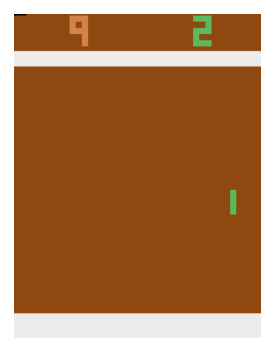

In [11]:
#model2 = pickle.load(open('save_tr.p', 'rb'))
#env = gym.make("Pong-v0")
play_game(env, model)